# 비율추정

정보이론, 추론, 알고리즘학습에서 데이비드 맥케이는 다음의 문제를 제안했다. 

- 벨기에 1유로 동전을 축을 중심으로 250번 회전을 시켰는데, 앞면이 140회 뒷면은 110회가 나왔다. 런던 경제학교 통계학교수 배리 브라이트는 이 결과가 동전이 한 쪽으로 기울어지지 않았다면, 결과가 이렇게 치우칠 확률은 7% 미만이라 주장했다.
- 이 때 이 데이터가 동전이 한 쪽으로 기울었다는 것의 증거가 될까?
- 일반적으로 앞이 나올 확률을 p라고 하고, 동전을 n회 던졌다고 가정할 때 앞면이 총 k회 나올 확률은 이항분포에서 확인할 수 있다.
- $$\binom{n}{k}p^{k}(1-p)^{n-k}$$

In [1]:
from scipy.stats import binom

# 2 회 동전을 던져, k회 앞면이 나올 확률
n = 2
p = 0.5
k = 1
binom.pmf(k,n,p)

0.5000000000000002

In [2]:
import numpy as np
ks = np.arange(n+1) # 0,1,2
ps = binom.pmf(ks,n,p)
ps

array([0.25, 0.5 , 0.25])

In [3]:
from empiricaldist import Pmf

pmf_k = Pmf(ps,ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [4]:
# 주어진 n과 p에 대한 이항분포를 구하여 이를 나타내는 Pmf 결괏값으로 반환하는 함수

def make_binomial(n:int,p:float)->Pmf:
    """
    주어진 n과 p에 대한 이항분포를 구하여 이를 나타내는 Pmf 결괏값으로 반환하는 함수
    empiricaldist.Pmf(ps,ks) = Pmf(각 확률, index)
    """
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps,ks)  

In [5]:
# n = 250, p = 0.5 일 때의 pmf

binomial_pmf = make_binomial(250,0.5)

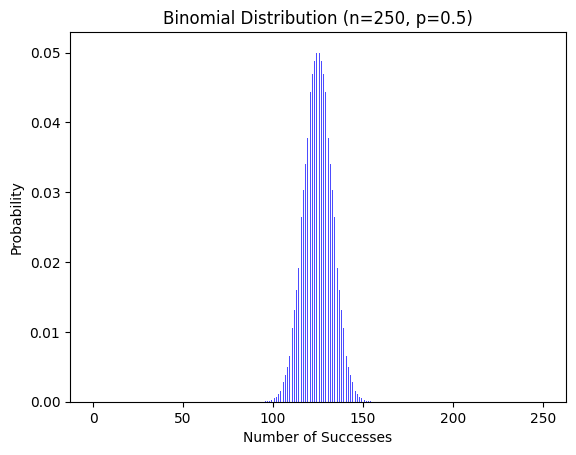

In [6]:
# 이항분포를 그래프로 시각화
import matplotlib.pyplot as plt

plt.bar(binomial_pmf.qs, binomial_pmf.ps, width=0.5, color='blue', alpha=0.7) # plt.bar(x,y, width, color, alpha)
plt.title('Binomial Distribution (n=250, p=0.5)')
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.show()

In [7]:
def prob_ge(pmf:Pmf, threshold:int)->float:
    """임계점보다 크거나 같은 값이 가지는 총 확률"""
    ge = (pmf.qs >= threshold) # boolean list
    total = pmf[ge].sum()
    return total

In [8]:
prob_ge(binomial_pmf,140)

0.03321057562002166

In [9]:
binomial_pmf.prob_ge(140)

0.03321057562002166

# 베이지안추정

- 어떤 동전이든 세워서 돌리면 앞면을 보이며 넘어질 확률을 가진다. 이 확률을 여기서는 x라고 하자. x는 무게 분산 등 물리적 특성에 영향을 받는다고 충분히 생각할 수 있다. 만약 동전의 무게가 완벽한 균형을 이루고 있다면 우리는 x가 50%에 근접하리라 생각하겠지만, 어느 한 쪽에 치우쳐져 있다면 x는 이에 따라 달라진다. 이럴 때 베이즈 정리와 관측 데이터를 사용해서 x를 추정할 수 있다.
- 간단한 예로, 우선 x의 모든 값이 동일한 정도로 가능하다고 가정하는 균등분포를 사전분포로 놓고 시작해보자. 

In [10]:
# 균등사전분포

hypos = np.linspace(0,1,101)
prior = Pmf(1,hypos)
likelihood_heads = hypos
likelihood_tails = 1 - hypos
likelihood = {
    'H':likelihood_heads,
    'T':likelihood_tails
}

In [11]:
dataset = 'H' * 140 + 'T' * 110

In [12]:
def update_euro(pmf, dataset):
    """주어진 H와 T의 문자열로 pmf를 갱신함"""
    for data in dataset:
        pmf *= likelihood[data]
    pmf.normalize()

In [13]:
posterior = prior.copy()
update_euro(posterior, dataset)

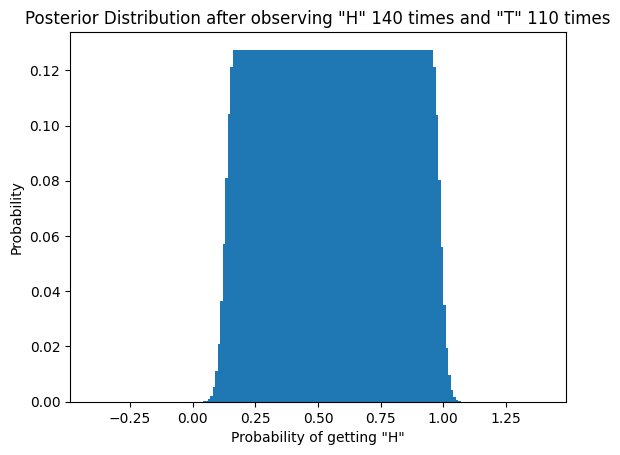

In [14]:
plt.bar(posterior.qs, posterior.ps, label = 'Posterior') # plt.bar(x,y, width, color, alpha)
plt.title('Posterior Distribution after observing "H" 140 times and "T" 110 times')
plt.xlabel('Probability of getting "H"')
plt.ylabel('Probability')
plt.show()

In [15]:
posterior.max_prob()

0.56

# 이항가능도함수

- 앞서 한 번 돌릴떄마다 확률을 갱신했으므로 유로 동전 문제에서는 갱신을 250번 했다. 
- 이에 대한 보다 효율적인 대안으로 전체 데이터셋의 가능도를 한번에 계산하는 방법이 있다. x에 대한 각 가설값에 대해 250회 회전 후 140회 앞면이 나올 확률을 계산할 수 있다.
- 이 문제에 대한 답은 이항분포의 사용이다. 

In [16]:
from scipy.stats import binom

def update_binomial(pmf:Pmf,data):
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k,n,xs) # binom.pmf(k,n,p)
    pmf *= likelihood # 각 구간별 새로운 확률값 얻기
    pmf.normalize()

In [17]:
uniform2 = Pmf(1,hypos, name = 'uniform2')
data = 140,250
update_binomial(uniform2, data)
print(uniform2)

0.00     0.000000e+00
0.01    1.256330e-207
0.02    5.731921e-166
0.03    8.338711e-142
0.04    8.269265e-125
            ...      
0.96     2.107677e-83
0.97     1.624102e-96
0.98    2.911941e-115
0.99    9.293081e-148
1.00     0.000000e+00
Name: uniform2, Length: 101, dtype: float64


# 문제 4-1

- 메이저리그에서 대부분의 선수는 평균 .200 에서 .330 정도의 타율이다. 즉 선수들이 안타를 칠 확률은 0.2~0.33 이라는 뜻이다.
- 첫 경기에 등장한 선수가 3번의 시도에서 3번의 안타를 쳤다고 하자. 그러면 안타를 칠 확률에 대한 사후분포는 어떻게 될까?

In [18]:
hypos = np.linspace(0.1,0.4,101) # 0.2~0.33 대신 약간씩 더 넓은 공간을 사용하여 변화를 포착, np.linspace 를 사용하는 것은 확률분포를 부드럽게 나타내기 위함
prior = Pmf(1, hypos)
print(prior)

0.100    1
0.103    1
0.106    1
0.109    1
0.112    1
        ..
0.388    1
0.391    1
0.394    1
0.397    1
0.400    1
Length: 101, dtype: int64


In [19]:
likelihood = { #likelihood : 성공 또는 실패
    'Y': hypos,
    'N': 1-hypos
}

In [20]:
# 각 시행에 대한 확률. 100번 중 0번 맞췄다면 0, 100번 중 1번 맞췄다면 0.01 ... 100번 중 100번 맞췄다면 1이 된다.
# 즉 베르누이 분포의 가설 공간
likelihood['Y']  

array([0.1  , 0.103, 0.106, 0.109, 0.112, 0.115, 0.118, 0.121, 0.124,
       0.127, 0.13 , 0.133, 0.136, 0.139, 0.142, 0.145, 0.148, 0.151,
       0.154, 0.157, 0.16 , 0.163, 0.166, 0.169, 0.172, 0.175, 0.178,
       0.181, 0.184, 0.187, 0.19 , 0.193, 0.196, 0.199, 0.202, 0.205,
       0.208, 0.211, 0.214, 0.217, 0.22 , 0.223, 0.226, 0.229, 0.232,
       0.235, 0.238, 0.241, 0.244, 0.247, 0.25 , 0.253, 0.256, 0.259,
       0.262, 0.265, 0.268, 0.271, 0.274, 0.277, 0.28 , 0.283, 0.286,
       0.289, 0.292, 0.295, 0.298, 0.301, 0.304, 0.307, 0.31 , 0.313,
       0.316, 0.319, 0.322, 0.325, 0.328, 0.331, 0.334, 0.337, 0.34 ,
       0.343, 0.346, 0.349, 0.352, 0.355, 0.358, 0.361, 0.364, 0.367,
       0.37 , 0.373, 0.376, 0.379, 0.382, 0.385, 0.388, 0.391, 0.394,
       0.397, 0.4  ])

In [21]:
dataset = "Y" * 25 + 'N' * 75

In [22]:
for data in dataset:
    prior = prior * likelihood[data]
prior.normalize()

1.3596964206970507e-23

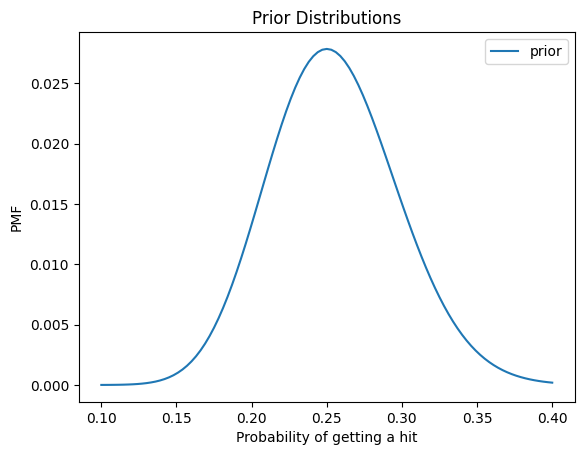

In [23]:
prior.plot(label = 'prior')
# title, x label, y label 추가
plt.title('Prior Distributions')
plt.xlabel('Probability of getting a hit')
plt.ylabel('PMF')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


In [24]:
posterior = prior.copy()

for data in 'YYY':
    posterior *= likelihood[data]
posterior.normalize()
print(posterior)

0.100    1.516431e-07
0.103    2.700909e-07
0.106    4.693670e-07
0.109    7.969007e-07
0.112    1.323462e-06
             ...     
0.388    1.277260e-03
0.391    1.096177e-03
0.394    9.375090e-04
0.397    7.990373e-04
0.400    6.786689e-04
Length: 101, dtype: float64


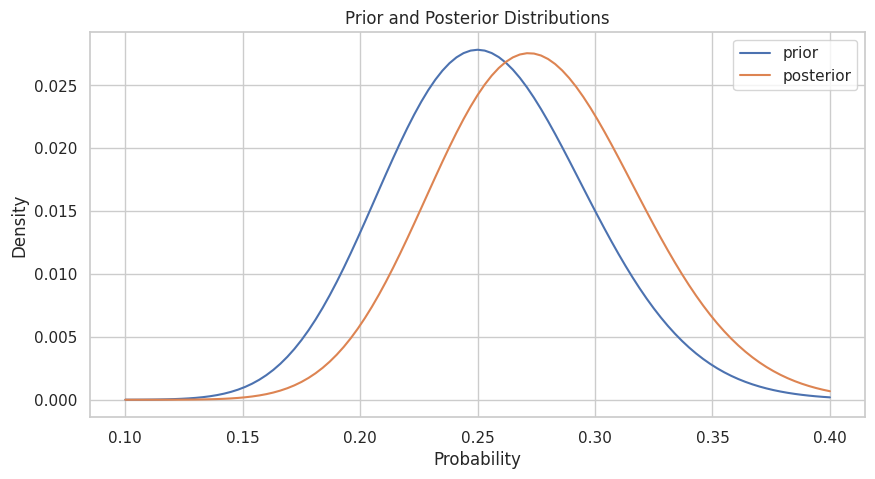

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그림의 가로 세로 비율 조절
plt.figure(figsize=(10, 5))

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 'prior'와 'posterior'를 라벨로 가진 그래프를 생성
prior.plot(label='prior')
posterior.plot(label='posterior')

# title, x label, y label 추가
plt.title('Prior and Posterior Distributions')
plt.xlabel('Probability')
plt.ylabel('Density')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


In [26]:
print(f'prior:{prior.idxmax()}')
print(f'posterior{posterior.idxmax()}')

prior:0.25
posterior0.271


# 문제 4-2

- 사람들에게 민감한 주제에 대해서 설문조사를 해야 하는 경우, 사회적 바람직성 편향에 대해 다루게 된다. 사회적 바람직성 편향이란 사람들이 자신을 가장 긍정적인 성향으로 나타내기 위해 답변을 조율하는 경향성을 말한다. 이를 피하고 답변의 정확도를 높이는 한 가지 방법은 답변을 무작위로 섞는 것이다. 
- 하나의 예로, 얼마나 많은 사람들이 탈세를 하는지를 파악하고자 한다. 만약 사람들에게 이를 직접 물어본다면, 일부 탈세자는 거짓말을 한다. 이를 돌려서 물어본다면 보다 정확한 추정이 가능하다.
- 예를 들면 다음과 같다. 각 사람들에게 동전을 던지고, 그 결과를 공개하지 말고 다음 내용에 따르라고 한다. 
- 만약 앞면이 나온다면 '네'라고 대답한다.
- 만약 뒷면이 나온다면 '탈세했나요?' 라는 질문에 대답한다. 
- 누군가 '네'라고 대답했다면, 우리는 그가 실제로 탈세를 했는지 모른다. 그가 앞면이 나왔을 수 있다. 이를 이해한다면, 사람들은 보다 솔직하게 대답할 수 있다.
- 이와 같은 방식으로 100명의 사람에게 설문을 했고, 80명이 '네'라고 했고 20명이 '아니요'라고 했다. 이 데이터에 따르면, 실제 탈세자 비율의 사후확률분포는 어떻게 될까? 사후확률이 가장 높은 탈세자 비율은 얼마일까?

In [27]:
# hypos = hypothesis, 어떤 값을 취할 수 있는 변수들의 집합 또는 범위
hypos = np.linspace(0,1,101)
# 사전분포는 큰 의미 없으니 신경 쓰지 말자. 
prior = Pmf(1, hypos)
print(prior)

0.00    1
0.01    1
0.02    1
0.03    1
0.04    1
       ..
0.96    1
0.97    1
0.98    1
0.99    1
1.00    1
Length: 101, dtype: int64


In [28]:
likelihood = { # 각 가설에서 사건(cheating)이 발생할 확률
    'Y': 0.5 + hypos/2,
    'N': (1-hypos)/2
}

In [29]:
likelihood['Y'] # cheating이 한번도 없었다면 Y가 발생할 확률은 0.5, 한번 있었다면 0.505... 

array([0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 ,
       0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585,
       0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 ,
       0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675,
       0.68 , 0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 ,
       0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765,
       0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 ,
       0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855,
       0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  ,
       0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 , 0.945,
       0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 ,
       0.995, 1.   ])

In [30]:
likelihood['N']

array([0.5  , 0.495, 0.49 , 0.485, 0.48 , 0.475, 0.47 , 0.465, 0.46 ,
       0.455, 0.45 , 0.445, 0.44 , 0.435, 0.43 , 0.425, 0.42 , 0.415,
       0.41 , 0.405, 0.4  , 0.395, 0.39 , 0.385, 0.38 , 0.375, 0.37 ,
       0.365, 0.36 , 0.355, 0.35 , 0.345, 0.34 , 0.335, 0.33 , 0.325,
       0.32 , 0.315, 0.31 , 0.305, 0.3  , 0.295, 0.29 , 0.285, 0.28 ,
       0.275, 0.27 , 0.265, 0.26 , 0.255, 0.25 , 0.245, 0.24 , 0.235,
       0.23 , 0.225, 0.22 , 0.215, 0.21 , 0.205, 0.2  , 0.195, 0.19 ,
       0.185, 0.18 , 0.175, 0.17 , 0.165, 0.16 , 0.155, 0.15 , 0.145,
       0.14 , 0.135, 0.13 , 0.125, 0.12 , 0.115, 0.11 , 0.105, 0.1  ,
       0.095, 0.09 , 0.085, 0.08 , 0.075, 0.07 , 0.065, 0.06 , 0.055,
       0.05 , 0.045, 0.04 , 0.035, 0.03 , 0.025, 0.02 , 0.015, 0.01 ,
       0.005, 0.   ])

In [31]:
posterior = prior.copy()
answer = 'Y' * 80 + 'N' * 20
for ans in answer:
    posterior *= likelihood[ans]
posterior.normalize()

3.6945139133967024e-21

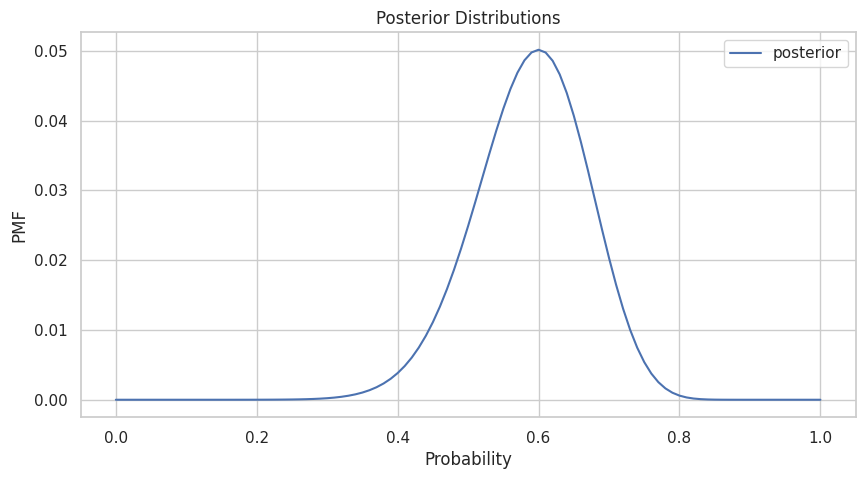

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그림의 가로 세로 비율 조절
plt.figure(figsize=(10, 5))

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 'prior'와 'posterior'를 라벨로 가진 그래프를 생성
# prior.plot(label='prior')
posterior.plot(label='posterior')

# title, x label, y label 추가
plt.title('Posterior Distributions')
plt.xlabel('Probability')
plt.ylabel('PMF')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

# 문제 4-3

- 동전이 공정한지를 실험해보고자 하지만, 이를 수백번 돌리고 싶지는 않다. 그래서 자동으로 동전을 돌리는 기계를 만들었고, 이미지 인식으로 결과를 파악하도록 했다. 
- 하지만 기계가 늘 정확하지 않다는 사실을 알게 되었다. 실제 앞면이 나왔는데 뒷면이라고 기록되었거나, 실제 뒷면인데 앞면이라고 기록된 확률을 $ y = 0.2 $ 라고 해보자. 
- 만약 동전을 250회 돌렸고, 기계가 앞면이 140회 나왔다고 했을 때 x의 사후확률분포는 어떻게 될까? y의 값을 바꾸면 어떻게 될까?

In [35]:
hypos = np.linspace(0,1,101) # 각 시행이 일어날 확률
prior = Pmf(1,hypos)
dataset = 'H' * 140 + 'T' * 110

def update_reliability(pmf:Pmf, dataset, y):
    likelihood = {
        'H': (1-y) * hypos + y*(1-hypos) ,
        'T': y * hypos + (1-y) * (1-hypos)
    }
    for data in dataset:
        pmf *= likelihood[data]
    pmf.normalize()

In [36]:
posterior00 = prior.copy()
update_reliability(posterior00, dataset, 0.2)

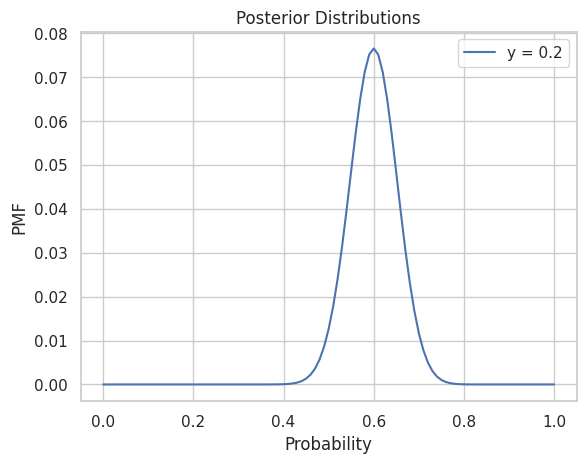

In [38]:
posterior00.plot(label= 'y = 0.2')
# title, x label, y label 추가
plt.title('Posterior Distributions')
plt.xlabel('Probability')
plt.ylabel('PMF')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

# 문제 4-4

- 외계인의 침공에 대비하여 지구방위연맹은 우주 침략자를 쏘아 맞출 새로운 미사일을 개발해왔다. 몇몇 미사일은 다른 것보다 더 잘 설계되었다. 이 떄 각 설계별로 외계 우주선을 맞출 확률 x를 가정해보자.
- 이전 실험에 따르면, 각 설계별 x의 분포는 대략 0.1과 0.4 사이에서 균등분포를 이룬다.
- 이번의 새로운 설계안 A를 실험한다고 하자. 기사에 따르면 소장은 새 설계안으로 두 번 실험을 했고, 각 실험에서 두 번 발사했다. 실험결과는 비밀이라 소장은 얼마나 많은 목표물을 격추했는지는 언급하지 않았으나, 기사에서 발표한 바로는 "두 번의 실험결과에서 동일한 수의 목표물이 격추되었으므로 새 설계안은 일관성이 있다" 고 발표했다.
- 이 데이터는 좋은가, 아니면 나쁜가? 즉 이 데이터로 A의 x에 대한 추정값이 증가하는가 혹은 감소하는가?
- hint: 각 타겟을 맞출 확률이 $x$라면, 두 개의 실험에서 타겟을 맞출 확률은 $[2x(1-x)]^{2}$이다.

In [ ]:
hypos = np.linspace(0.1,0.4, 101)
prior = Pmf(1, hypos) # x가 0.1 에서 0.4까지 증가하는 101개의 가설에 대해 동일한 확률 1이 배정되었음

x = hypos
n = 2
likes2 = [binom.pmf(k,n,x)**2 for k in range(n+1)]
likelihood2 = np.sum(likes2, axis = 0)

In [39]:
print(prior)

0.00    1
0.01    1
0.02    1
0.03    1
0.04    1
       ..
0.96    1
0.97    1
0.98    1
0.99    1
1.00    1
Length: 101, dtype: int64
